In [1]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import pybloom
utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/home/reddit/CivilServant"
sys.path.append(BASE_DIR)

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)

### LOAD PRAW
import reddit.connection
conn = reddit.connection.Connect(base_dir=BASE_DIR, env="jupyter")

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

### Load PRAW session

In [2]:
r = conn.connect(controller="ModLog")

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
POST: https://api.reddit.com/api/v1/access_token/
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json


### Load Official Historical r/science posts

In [3]:
post_ids = pybloom.BloomFilter(capacity=10000000, error_rate = .000000001)
science_posts = []
files = ['/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_to_12_2015.json',
 '/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_12_2015.json',
 '/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_01_2016.json',
 '/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_02_2016.json',
 '/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_03_2016.json',
 '/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_04_2016.json',
 '/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_05_2016.json']
counter = 0
for file in files:
    print
    sys.stdout.write(file)
    sys.stdout.flush()
    with open(file, "r") as lines:
        for line in lines:
            post = json.loads(line)
            if post['id'] not in post_ids:
                post['created'] = utc.localize(datetime.datetime.utcfromtimestamp(int(post['created_utc'])))
                science_posts.append(post)
                post_ids.add(post['id'])
            counter += 1
            if(counter % 1000) == 0:
                sys.stdout.write(".")
                sys.stdout.flush()

/mnt/corsair/reddit_archive/official-bigquery-data/science_posts_to_12_2015.json..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................../mnt/corsair/reddit_archive/official-bigquery-data/science_posts_12_2015.json...../mnt/corsair/reddit_archive/official-bigquery-data/science_posts_01_2016.json...../mnt/corsair/reddit_archive/official-bigquery-data/science_posts_02_2016.json...../mnt/corsair/reddit_archive/official-bigquery-data/science_posts_03_2016.json...../mnt/corsair/reddit_archive/

### Load Baumgartner Posts from the last month (includes some gaps)

In [4]:
head = parser.parse('2016-06-01 00:00:00 UTC')
tail = parser.parse('2016-06-30 23:59:59 UTC')
with open("/mnt/corsair/reddit_archive/baumgartner-bigquery-data/reddit_science_posts_2016.json", "r") as lines:
    for line in lines:
        post = json.loads(line)
        post['created'] = parser.parse(post['created_utc'])
        if(post['created'] >= head and
           post['created'] <= tail and post['id'] not in post_ids):
            post['day.num'] = (post['created'] - utc.localize(datetime.datetime(1970,1,1))).days
            science_posts.append(post)
            post_ids.add(post['id'])


### Create a Pandas Dataframe from data

In [5]:
posts_df = pd.DataFrame(science_posts)

### Plot posts per day in the entire history of the subreddit

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  app.launch_new_instance()


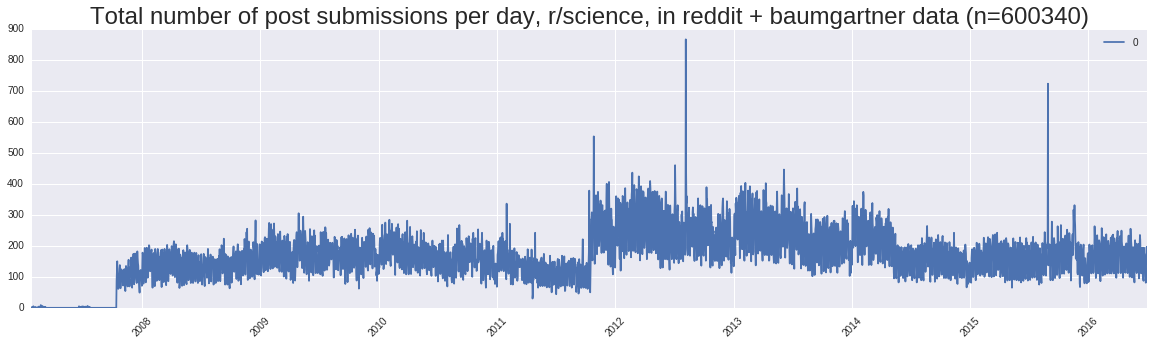

In [6]:
x = pd.DataFrame(posts_df.created.values, index=posts_df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D", how="count").plot(rot=45, ax=ax)
plt.title("Total number of post submissions per day, r/science, in reddit + baumgartner data (n={0})".format(posts_df.created.count()), fontsize="24")

In [13]:
posts_df[posts_df.created>parser.parse('2016-04-01 00:00:00 UTC')].created.count()

15371

### Load Moderator Actions Going Back to April 4, 2016

In [15]:
recent_mod_actions = []
for row in db_engine.execute(text('select action_data from mod_actions WHERE subreddit_id="mouw" ORDER BY created_utc;')):
    mod_action = json.loads(row['action_data'])
    mod_action['created'] = utc.localize(datetime.datetime.utcfromtimestamp(mod_action['created_utc']))
    recent_mod_actions.append(mod_action)

### Tag posts as visible or non-visible based on moderation log

In [16]:
posts_2016 = {}
for post in posts_df[posts_df.created>=recent_mod_actions[0]['created']].to_dict("records"):
    post['visible'] = True
    posts_2016[post['id']] = post
recent_post_count = len(posts_2016.values())
print("Recent Post Count: {0}".format(recent_post_count))

Recent Post Count: 14777


### Find missing posts mentioned in the moderation log

In [17]:
missing_mod_actions = []
matched_mod_actions = 0
for action in recent_mod_actions:
    if action['action'] == "removelink":
        key = action['target_fullname'].replace("t3_","")
        if key in posts_2016.keys():
            posts_2016[key]['visible'] = False
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
    elif action['action'] == 'approvelink':
        key = action['target_fullname'].replace("t3_","")
        if key in posts_2016.keys():
            posts_2016[key]['visible'] = True
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
print("Missing Mod Actions: {0}".format(len(missing_mod_actions)))
print("Missing Mod Action Posts: {0}".format(len(set(missing_mod_actions))))
print("Matched Mod Actions: {0}".format(matched_mod_actions))

Missing Mod Actions: 783
Missing Mod Action Posts: 543
Matched Mod Actions: 15085


### Fetch missing posts from reddit

In [18]:
extra_posts = []
for submission in r.get_submissions(["t3_" + x for x in set(missing_mod_actions)]):
    extra_posts.append(submission.json_dict)

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/by_id/t3_4r6p01,t3_4rcox9,t3_4r59ol,t3_4rhwzd,t3_4r8vq2,t3_4rilez,t3_4qxeav,t3_4qs7ww,t3_4re0q6,t3_4qr4j8,t3_4r4g31,t3_phvr1,t3_4rbjy4,t3_4qpvx5,t3_to7tq,t3_4r1x6u,t3_bi7l5,t3_4rj63c,t3_4qpwep,t3_4rbuvz,t3_4qs7x1,t3_4rcfm9,t3_4qu9kz,t3_4apkpb,t3_4r5csu,t3_4rbkmu,t3_4rfi0y,t3_4qwz9j,t3_4rbirh,t3_4dco4y,t3_4qv47s,t3_4rgyyv,t3_4r7196,t3_4qqvhl,t3_476d3i,t3_4qsk14,t3_4rhm7n,t3_4r6ymb,t3_4qs9c1,t3_4ri8s1,t3_4rbivj,t3_4rh102,t3_4rams4,t3_4rhrpx,t3_4rhnyj,t3_4rbqv5,t3_4qp9t1,t3_4qzpw8,t3_4r0qsh,t3_4d8rhv,t3_4r3q2z,t3_4r0gw0,t3_4ravgm,t3_4r0bsv,t3_4rcedl,t3_4qs056,t3_4qyxug,t3_4rc7ih,t3_4ra3a3,t3_4qxc0d,t3_4rehy5,t3_4r76ne,t3_4rbieu,t3_4483en,t3_4qufc0,t3_4rhlws,t3_4qpucu,t3_4qr2iw,t3_4r6xvy,t3_4qwwq8,t3_4rds38,t3_4dbjdi,t3_4danct,t3_4r1awr,t3_4ri96j,t3_4ri26g,t3_4r4upm,t3_4rhxzn,t3_4qtus5,t3_4qp5kh,t3_4rhz29,t3_4r5fry,t3_4r6urn,t3_4rhozv,t3_4r8lqk,t3_4r6eu7,t3_4qqptn,t3_k2gru,t3_4qzitr,t3_4re

In [19]:
### AND NO NEED TO GO BACK THROUGH THE MODERATION ACTION LIST
### FOR THESE, SINCE THEY WILL HAVE THE banned_by PROPERTY

outside_time_window = 0
within_time_window = 0

for post in extra_posts:
    post['created'] = utc.localize(datetime.datetime.utcfromtimestamp(int(post['created_utc'])))
    if post['created'] >= recent_mod_actions[0]['created'] and post['created'] <= tail:
        if(post['banned_by'] is not None):
            post['visible'] = False
        else:
            post['visible'] = True
        posts_2016[post['id']] = post
        within_time_window += 1
    else:
        outside_time_window += 1
    
print("Extra posts within time window: {0}".format(within_time_window))
print("Extra posts outside time window: {0}".format(outside_time_window))
    
for post in posts_2016.values():
    post['day.num'] = (post['created'] - utc.localize(datetime.datetime(1970,1,1))).days

Extra posts within time window: 0
Extra posts outside time window: 543


### Create Dataframe to Chart Submitted versus Permitted Posts Per Day

In [20]:
recent_posts = pd.DataFrame(list(posts_2016.values()))
print("Posts before update from modlog: {0}".format(recent_post_count))
print("Posts after update from modlog: {0}".format(recent_posts.created.count()))

Posts before update from modlog: 14777
Posts after update from modlog: 14777


### Plot Posts Per Day in Recent History of Subreddit

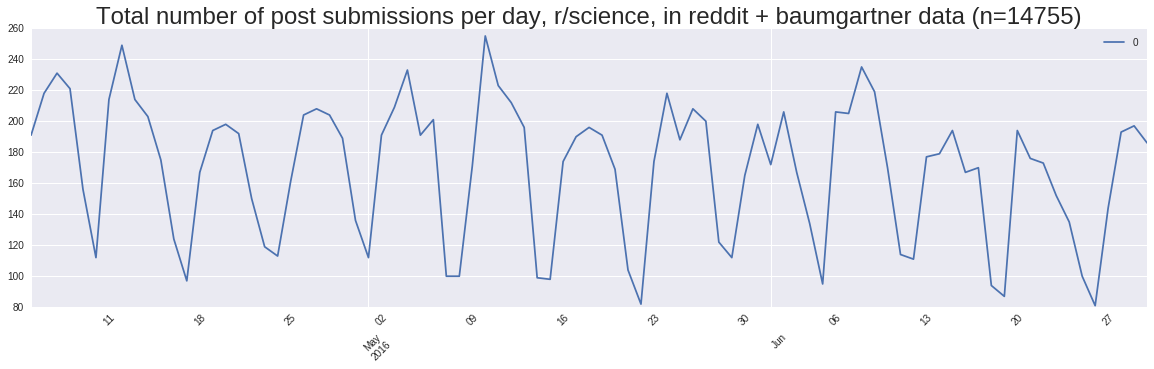

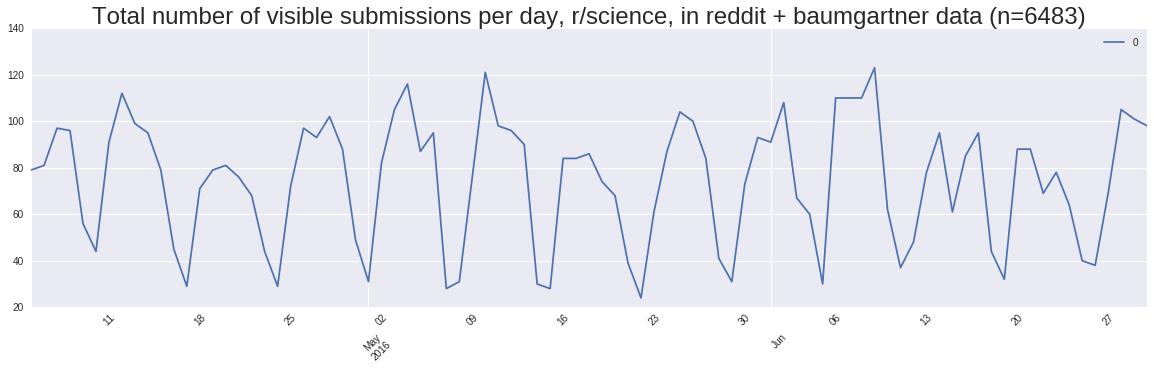

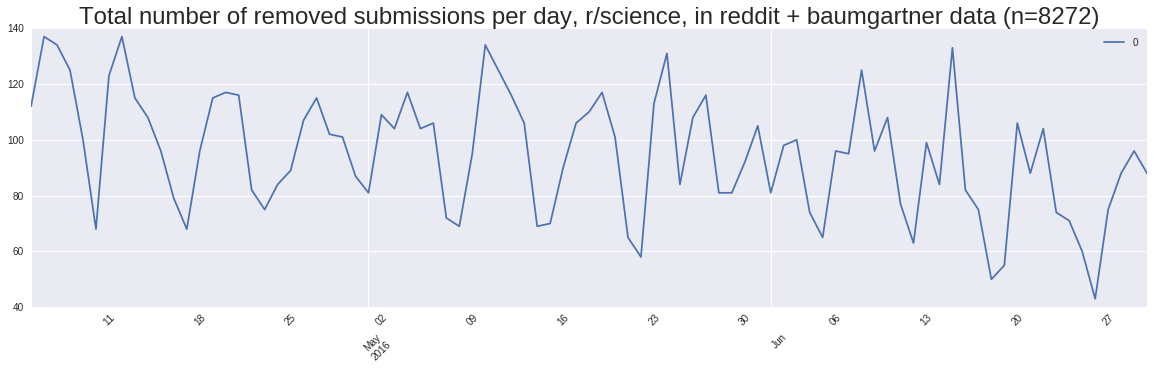

In [21]:
### TOTAL SUBMISSIONS
df = recent_posts[((recent_posts.created <= parser.parse("2016-07-01 00:00:00 UTC")) &
                   (recent_posts.created >= parser.parse("2016-04-05 00:00:00 UTC")))]
x = pd.DataFrame(df.created.values, index=df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D").count().plot(rot=45, ax=ax)
plt.title("Total number of post submissions per day, r/science, in reddit + baumgartner data (n={0})".format(df.created.count()), fontsize="24")
plt.show()

total_counts = x.resample("D").count().to_dict("records")

### NOW ACCEPTED SUBMISSIONS
df = recent_posts[((recent_posts.visible == True) & 
                   (recent_posts.created <= parser.parse("2016-07-01 00:00:00 UTC")) &
                   (recent_posts.created >= parser.parse("2016-04-05 00:00:00 UTC")))]
x = pd.DataFrame(df.created.values, index=df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D").count().plot(rot=45, ax=ax)
plt.title("Total number of visible submissions per day, r/science, in reddit + baumgartner data (n={0})".format(df.created.count()), fontsize="24")
plt.show()

retained_counts = x.resample("D").count().to_dict("records")

### NOW REMOVED SUBMISSIONS
df = recent_posts[((recent_posts.visible == False) & 
                   (recent_posts.created <= parser.parse("2016-07-01 00:00:00 UTC")) & 
                   (recent_posts.created >= parser.parse("2016-04-05 00:00:00 UTC")))]
x = pd.DataFrame(df.created.values, index=df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D").count().plot(rot=45, ax=ax)
plt.title("Total number of removed submissions per day, r/science, in reddit + baumgartner data (n={0})".format(df.created.count()), fontsize="24")
plt.show()

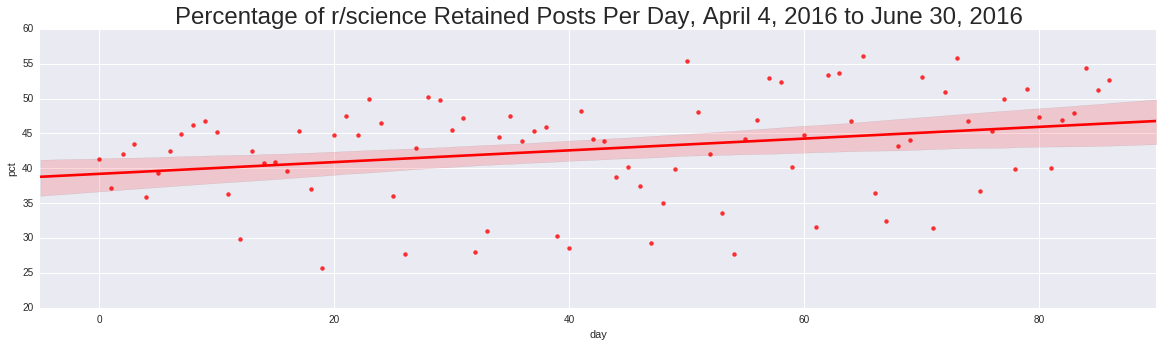

In [22]:
retained_proportion_per_day = []
for i in range(0,len(total_counts)):
    retained_proportion_per_day.append({
            "day":i,
            "pct": (float(retained_counts[i][0]) / float(total_counts[i][0]) * 100.)
            })
recent_prop_df = pd.DataFrame(retained_proportion_per_day)

fig, ax = plt.subplots(figsize=(20,5))
ax.set_xlim(left=-5, right=90)
sns.regplot(x="day", y="pct", data=recent_prop_df,ax=ax, color="R")
plt.title("Percentage of r/science Retained Posts Per Day, April 4, 2016 to June 30, 2016", fontsize="24")

# Construct Dependent Variables: 
* newcomer comments on posts that are allowed to remain
* the number of newcomer comments on posts that are allowed to remain
* the number of removed newcomer comments on posts that are allowed to remain

### Load last six months of comments from official reddit dataset

In [9]:
comment_head = parser.parse("2015-12-01 00:00:00 UTC")
all_comments = {}
comment_ids = pybloom.BloomFilter(capacity=10000000, error_rate = .000000001)

for filename in [#'/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_12_2015.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_01_2016.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_02_2016.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_03_2016.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_04_2016.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_05_2016.json']:
    sys.stdout.write(".")
    sys.stdout.flush()
    with open(filename, "r") as lines:
        for line in lines:
            comment = json.loads(line)
            if(comment['id'] not in comment_ids):
                comment['created'] = utc.localize(datetime.datetime.utcfromtimestamp(float(comment['created_utc'])))
                comment['visible'] = True
                if(comment['body'] == "[removed]"):
                    comment['visible'] = False
                comment['body.length'] = len(comment['body'])
                comment['body'] = None
                comment['body_html'] = None
                all_comments[comment['id']] = comment
                comment_ids.add(comment['id'])

.....

### Load Baumgartner Comments from the last month
Unlike the post data, I checked this and found no gaps, at least going from the moderation log


In [23]:
tail = parser.parse('2016-05-30 23:59:59 UTC')
count = 0
with open("/mnt/corsair/reddit_archive/baumgartner-bigquery-data/reddit_science_comments_2016.json", "r") as comment_file:
    for line in comment_file:
        comment = json.loads(line)
        if(comment['id'] not in comment_ids):
            comment['created'] = parser.parse(comment['created_utc'])
            if(comment['created'] <= tail):
                comment['body.length'] = len(comment['body'])
                comment['body'] = None
                comment['body_html'] = None
                comment['visible'] = True
                if(comment['body'] == "[removed]"):
                    comment['visible'] = False
                all_comments[comment['id']] = comment
                comment_ids.add(comment['id'])
        count += 1
        if(count % 50000 == 0):
            sys.stdout.write(".")
            sys.stdout.flush()

........

### Identify Missing Coments from Moderation Log

In [33]:
missing_comment_ids = []
for action in recent_mod_actions:
    if action['target_fullname'] is not None and "t1_" in action['target_fullname']:
        if action['target_fullname'].replace("t1_", "") not in all_comments.keys():
            missing_comment_ids.append(action['target_fullname'])
print("Missing Comments: {0}".format(len(missing_comment_ids)))

### FETCH COMMENT INFORMATION FOR ALL MISSING COMMENTS
missing_comments = []
counter = 0
for comment_obj in r.get_info(thing_id=missing_comment_ids):
    comment = comment_obj.json_dict
    comment['created'] = utc.localize(datetime.datetime.utcfromtimestamp(float(comment['created_utc'])))
    comment['visible'] = True
    if(comment['body'] == "[removed]" or comment['banned_by'] is not None):
        comment['visible'] = False
    comment['body.length'] = len(comment['body'])
    comment['body'] = None
    comment['body_html'] = None
    missing_comments.append(comment)
    counter += 1

Missing Comments: 35360


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com

In [34]:
print("Found {0} additional comments moderated during the newcomer period and moderation log period".format(len(missing_comments)))
print("{0} of these comments have the author [deleted]".format(len([x for x in missing_comments if x['author']=="[deleted]"])))
print("{0} of these comments were removed.".format(len([x for x in missing_comments if x['visible']==False])))
mod_action_head = recent_mod_actions[0]['created']
comments_in_comment_period = len([x for x in missing_comments if (mod_action_head < x['created'] and tail >= x['created'])])
print("{0} of these fall within the period covered by the moderation log.".format(comments_in_comment_period))

newcomer_head = parser.parse("2016-01-01 00:00:00 UTC")
comments_in_newcomer_period = len([x for x in missing_comments if (newcomer_head < x['created'] and tail >= x['created'])])
print("{0} of these fall within the period used for calculating newcomers.".format(comments_in_newcomer_period))

added_count = 0
for comment in missing_comments:
    if(comment['created'] >= newcomer_head and comment['created'] <= tail):
        all_comments[comment['id']] = comment
        added_count +=1
print("")
print("{0} comments added to all_comments".format(added_count))

Found 35360 additional comments moderated during the newcomer period and moderation log period
2981 of these comments have the author [deleted]
32223 of these comments were removed.
0 of these fall within the period covered by the moderation log.
0 of these fall within the period used for calculating newcomers.

0 comments added to all_comments


### Construct a time sorted list of comments

In [35]:
import heapq

class CommentHeapObj(object):
    def __init__(self, comment):
        self.index = int(comment['created_utc'])
        self.val = comment
    def __lt__(self, other):
        return self.index < other.index

def heapsort(comments):
    h = []
    for comment in comments:
        heapq.heappush(h, CommentHeapObj(comment))
    return [heapq.heappop(h).val for i in range(len(h))]

all_comments = heapsort(all_comments.values())

### Add Moderation Actions to Comments, Setting Comments as Visible or Not Visible

In [38]:
from collections import defaultdict, Counter
mod_comment_actions = defaultdict(list)
approved_count = 0
removed_count = 0
total_coments_removed_at_least_once = []
comments_with_mod_actions = set()

for action in recent_mod_actions:
     if action['action'] == "removecomment" or action['action'] == "approvecomment":
            comment_id = action['target_fullname'].replace("t1_", "")
            mod_comment_actions[comment_id].append(action)
            comments_with_mod_actions.add(action['target_fullname'])

print("{0} Total moderation actions".format(sum([len(x) for x in mod_comment_actions.values()])))
print("{0} Comments with moderation actions".format(len(mod_comment_actions)))
print("{0} Comments with more than one mod action".format(len([x for x in mod_comment_actions.values() if len(x)>1])))
print("")

for comment in all_comments:
    if('later_deleted' not in comment.keys()):
        comment['later_deleted'] = False
        if(comment['author'] =="[deleted]"):
            comment['later_deleted'] = True
    if comment['id'] in mod_comment_actions.keys():
        for action in mod_comment_actions[comment['id']]:
            ## many authors are later deleted, so try to 
            ## add in the author information here, since
            ## the moderation log retains the author information
            comment['author']  = action['target_author']
            if action['action'] =="removecomment":
                removed_count += 1
                total_coments_removed_at_least_once.append(comment['id'])
                comment['visible'] = False
            elif action['action'] == "approvecomment":
                approved_count += 1
                comment['visible']  = True
print("Summary of Comment Visibility:")
print(Counter([x['visible'] for x in all_comments]))
print("Took {0} actions to set a comment to removed".format(removed_count))
print("Took {0} actions to set a comment to approved".format(approved_count))

112185 Total moderation actions
96084 Comments with moderation actions
10770 Comments with more than one mod action

Summary of Comment Visibility:
Counter({True: 276187, False: 159247})
Took 71330 actions to set a comment to removed
Took 6963 actions to set a comment to approved


### Add Author Comment Number to All Comments

In [39]:
author_comment_num = defaultdict(int)

for comment in all_comments:
    comment['author.prev.comments'] = author_comment_num[comment['author']]    
    author_comment_num[comment['author']] += 1


### Add Author Removed Count to All Comments

In [40]:
from collections import defaultdict, Counter

author_removed_num = defaultdict(int)

for comment in all_comments:
    comment['author.prev.removed'] = author_removed_num[comment['author']]  
    if(comment['visible']==False):
        author_removed_num[comment['author']] += 1

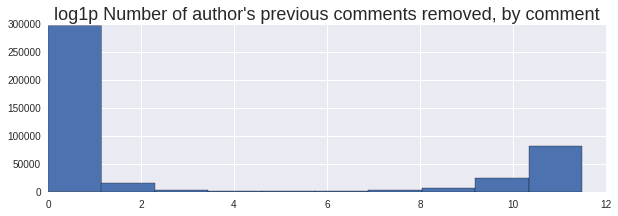

In [41]:
import math
plt.figure(figsize=(10, 3)) 
plt.hist([math.log1p(x['author.prev.removed']) for x in all_comments])
plt.title("log1p Number of author's previous comments removed, by comment", fontsize="18")
plt.show()

# Create Dataframes for Analysis

### Create a Dataset of Comments from April 4 2016 going forward
Tagged comments with information about the post they were attached to, including:
* were they top-level comments or replies?
* what flair did the post have
* what time was the post made
* was the post removed

In [42]:
comment_head = recent_mod_actions[0]['created']
recent_comments = [x for x in all_comments if x['created']>=comment_head and x['created']<= tail]
print("Total number of comments: {0}".format(len(all_comments)))
print("Recent comments: {0}".format(len(recent_comments)))

Total number of comments: 435434
Recent comments: 166614


#### Fetch any missing posts

In [43]:
recent_comment_posts = list(set([x['link_id'] for x in recent_comments]))
unfetched_posts = []
for post in recent_comment_posts:
    if post.replace("t3_", "") not in posts_2016.keys():
        unfetched_posts.append(post)

new_posts_fetched = 0
#new_posts_saved = 0
for submission in r.get_submissions(unfetched_posts):
    new_posts_fetched += 1
    post = submission.json_dict
    post['created'] = utc.localize(datetime.datetime.utcfromtimestamp(int(post['created_utc'])))
#    we add all posts, so that we can fetch the covariates. But we omit them from the posts df
#    if(post['created'] > comment_head and post['created'] <= tail):
        

    post['day.num'] = (post['created'] - utc.localize(datetime.datetime(1970,1,1))).days
    ## we do actually want to get all posts in this set so we can add their covariates
    if(post['banned_by'] is not None):
        post['visible'] = False
    else:
        post['visible'] = True
    posts_2016[post['id']] = post
#    new_posts_saved ++ 1
print("Fetched {0} new posts".format(new_posts_fetched))
#print("Saved {0} new posts".format(new_posts_saved))

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/by_id/t3_4817ak,t3_44g4li,t3_4apkpb,t3_4d3dcw,t3_48wxsx,t3_493axr,t3_3qpaw9,t3_46eglm,t3_3z0dr7,t3_3yv7ww,t3_42msxr,t3_4cmnsy,t3_4d3shl,t3_4cx1xh,t3_4by4rt,t3_4bgzth,t3_3xu1te,t3_49u1iw,t3_4cr5my,t3_3wsqn4,t3_4dau7r,t3_4dbhiq,t3_4cpl6d,t3_4brtod,t3_4cblw6,t3_3qvj7a,t3_435z2u,t3_4db4ua,t3_4bbc65,t3_4cm4vb,t3_48kh83,t3_4ckc8g,t3_48x2oo,t3_4asg31,t3_3qqsku,t3_4d8ze4,t3_4306oe,t3_3qehrm,t3_4dbg7j,t3_3qyhtd,t3_41zr2t,t3_4d9sf8,t3_4d5bnm,t3_45cei3,t3_4d8b5v,t3_4d3b56,t3_4bduqg,t3_46k5y4,t3_4d7nqz,t3_3vnr69,t3_47ib1l,t3_4d1n89,t3_43o754,t3_4c9q4m,t3_4cr9uq,t3_4d47al,t3_458dmz,t3_4dcf9m,t3_4dbvuh,t3_3vauxn,t3_4an8dt,t3_4dbvmr,t3_3w9ud8,t3_3up38w,t3_42ssv2,t3_4dab9j,t3_4ddcxb,t3_49t5gf,t3_4acov4,t3_4axue8,t3_4came7,t3_4d4e7n,t3_4btbyb,t3_4anasi,t3_4dbimc,t3_49t3h8,t3_48njxg,t3_4483en,t3_4bpqou,t3_4dbgzh,t3_3omlnl,t3_49pd00,t3_49fiw7,t3_46gshl,t3_4d8fy8,t3_4dco4y,t3_4cmsqu,t3_41x3dy,t3_3zpkkl,t3

Fetched 159 new posts


#### Now attach post-level covariates to comments

In [44]:
def is_ama(flair):
    if(flair is None or (isinstance(flair, str))!=True):
        return None
    return "ama" in flair

def is_badpost(flair):
    if(flair is None or (isinstance(flair, str))!=True):
        return None
    return "badpost" in flair

def strip_ama(flair):
    if(flair is None or (isinstance(flair, str))!=True):
        return None
#    try:
    flairs = [x for x in flair.split() if("ama" not in x and "badpost" not in x)]
#    except:
#        import pdb;pdb.set_trace()
    if(len(flairs)==0):
        return None
    return flairs[0] ## Confirmed that this is always only one flair

for comment in recent_comments:
    post = posts_2016[comment['link_id'].replace("t3_", "")]
    
    comment['post.ama'] = is_ama(post['link_flair_css_class'])
    comment['post.badpost'] = is_badpost(post['link_flair_css_class'])
    comment['post.flair'] = strip_ama(post['link_flair_css_class'])
    comment['post.created'] = post['created']
    comment['post.author'] = post['author']
    comment['post.visible'] = post['visible']
    comment['toplevel'] = comment['link_id'] == comment['parent_id']
    comment['post.domain'] = post['domain']
    comment['post.day.num']  = post['day.num']
    comment['day.num'] = (comment['created'] - utc.localize(datetime.datetime(1970,1,1))).days
    comment['weekday'] = comment['created'].weekday()
    comment['weekend'] = (comment['weekday'] >=6)

In [45]:
import time
recent_comment_df = pd.DataFrame(recent_comments)
earliest_datetime = recent_comments[0]['created'].strftime("%Y.%m.%d_%H.%M.%S")
latest_datetime = recent_comments[-1]['created'].strftime("%Y.%m.%d_%H.%M.%S")
recent_comments_filename = "r_science_comments_" + earliest_datetime + "-" + latest_datetime + ".csv"
recent_comment_df.to_csv(os.path.join("outputs",recent_comments_filename))

In [51]:
print("{0} comments by newcomers".format(recent_comment_df[recent_comment_df['author.prev.comments']==0].created.count()))
#print("{0} newcomer comments that were removed")
print("{0} comments by newcomers that were removed".format(recent_comment_df[((recent_comment_df['author.prev.comments']==0) & (recent_comment_df.visible==False))].created.count()))
print("{0} comments by newcomers that were removed, whose accounts were not later deleted".format(recent_comment_df[((recent_comment_df['author.prev.comments']==0) & (recent_comment_df.visible==False) & (recent_comment_df.later_deleted==False))].created.count()))

52188 comments by newcomers
25538 comments by newcomers that were removed
17 comments by newcomers that were removed, whose accounts were not later deleted


#### Now Generate and output a post-level dataset

In [47]:
# from comment_head onward
#post_comments = {}
for post in posts_2016.values():
#    post['newcomer.commenters'] = set()
    post['newcomer.comments'] = 0
    post['newcomer.comments.removed'] = 0
    post['commenters'] = set()
    post['num.comments']  = 0
    post['num.comments.removed'] = 0
    post['post.ama'] = is_ama(post['link_flair_css_class'])
    post['post.badpost'] = is_badpost(post['link_flair_css_class'])
    post['post.flair'] = strip_ama(post['link_flair_css_class'])
    post['weekday'] = post['created'].weekday()
    post['weekend'] = (post['weekday'] >=6)
    
for comment in recent_comments:
    post = posts_2016[comment['link_id'].replace("t3_", "")]
    post['commenters'].add(comment['author'])
    post['num.comments'] += 1
    if(comment['visible']!=True):
        post['num.comments.removed'] +=1
    ## IF THE COMMENT AUTHOR IS A NEWCOMER
    if comment['author.prev.comments'] == 0:
        post['newcomer.comments'] += 1
        if(comment['visible']!=True):
            post['newcomer.comments.removed'] += 1

for post in posts_2016.values():
    post['num.commenters'] = len(post['commenters'])
    del post['commenters']

In [48]:
print("{0} posts overall".format(len(list(posts_2016.values()))))
print("{0} posts within the analysis period".format(len([x for x in posts_2016.values() if (x['created'] > comment_head and x['created'] <= tail)])))

14936 posts overall
9746 posts within the analysis period


In [49]:
recent_post_df = pd.DataFrame([x for x in posts_2016.values() if (x['created'] > comment_head and x['created'] <= tail)])
recent_posts_filename = "r_science_posts_" + earliest_datetime + "-" + latest_datetime + ".csv"
recent_post_df.to_csv(os.path.join("outputs", recent_posts_filename))

# Questions for the Experiment

### If we modify the rule postings, when should the treatment switch be thrown every day?

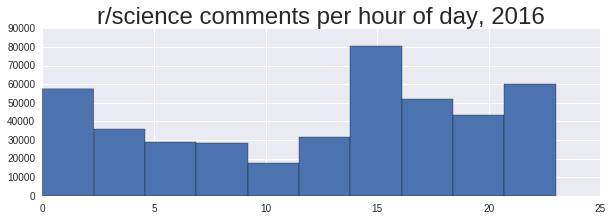

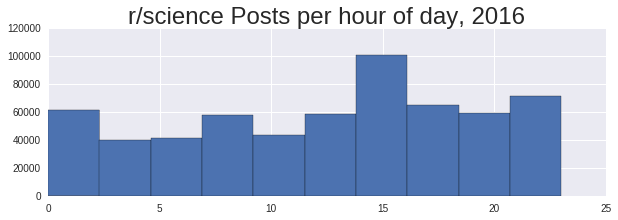

In [50]:
plt.figure(figsize=(10, 3)) 
plt.hist([x['created'].hour for x in list(all_comments)])
plt.title("r/science comments per hour of day, 2016", fontsize="24")
plt.show()

plt.figure(figsize=(10, 3)) 
plt.hist([x['created'].hour for x in science_posts])
plt.title("r/science Posts per hour of day, 2016", fontsize="24")
plt.show()
